<a href="https://colab.research.google.com/github/FernandoBRdgz/inteligencia_artificial/blob/main/representaciones_latentes/autocodificador_variacional_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introducción

Este *notebook* muestra como construir un autocodificador variacional, mejor conocido como Variational Autoencoder (VAE) entrenando un modelo en el conjunto de datos MNIST para generar nuevas imágenes.

---

El VAE es un tipo de modelo generativo basado en redes neuronales que se utiliza para aprender a generar nuevas muestras a partir de un conjunto de datos de entrada. Al igual que el autoencoder clásico, el VAE consta de un codificador y un decodificador, pero en lugar de utilizar una representación latente determinista, el VAE utiliza una distribución latente probabilística.

El objetivo del VAE es aprender a mapear la entrada a una distribución latente que represente una codificación compacta de los datos de entrada. La distribución latente se modela mediante una red neuronal conocida como "codificador probabilístico", que genera dos vectores de parámetros: la media y la desviación estándar de la distribución latente.

La codificación latente se utiliza para generar nuevas muestras mediante el proceso de decodificación. La decodificación se realiza mediante una red neuronal conocida como "decodificador generativo", que mapea un punto aleatorio en el espacio latente a una muestra generada.

Durante el entrenamiento, el VAE aprende a optimizar los parámetros del codificador y del decodificador de manera que las muestras generadas sean similares a los datos de entrada originales y la distribución latente se aproxime a una distribución de probabilidad estándar (generalmente, una distribución normal).

Para medir la calidad de las muestras generadas, se utiliza una función de pérdida que consta de dos términos: la pérdida de reconstrucción, que mide la diferencia entre las muestras generadas y los datos de entrada originales, y la pérdida de regularización, que mide la diferencia entre la distribución latente aprendida y la distribución de probabilidad estándar.

El VAE se utiliza en diversas aplicaciones, como la síntesis de imágenes, la generación de música y la modelización de lenguaje natural. Además, también puede utilizarse en la detección de anomalías, ya que puede generar muestras que son muy diferentes a los datos de entrada normales y, por lo tanto, detectar datos anómalos.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from IPython import display

In [ ]:
batch_size = 128
latent_dim = 2

In [ ]:
def map_image(image, label):
    image = tf.cast(image, dtype=tf.float32)
    image /= 255.0
    image = tf.reshape(image, shape=(28,28,1,))
    return image

In [ ]:
def get_dataset(map_fn, is_validation=False):
    if is_validation:
        split_name = "test"
    else:
        split_name = "train"
  
    dataset = tfds.load("mnist", as_supervised=True, split=split_name)
    dataset = dataset.map(map_fn)

    if is_validation:
        dataset = dataset.batch(batch_size)
    else:
        dataset = dataset.shuffle(1024).batch(batch_size)
  
    return dataset

In [ ]:
train_dataset = get_dataset(map_image, is_validation=False)
val_dataset = get_dataset(map_image, is_validation=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
# Dimensiones del primer lote
list(train_dataset.as_numpy_iterator())[0].shape

(128, 28, 28, 1)

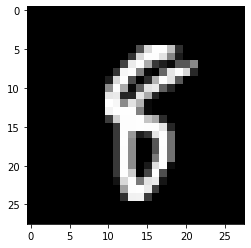

In [ ]:
 # Imagen del primer lote
 plt.imshow(list(train_dataset.as_numpy_iterator())[0][0], cmap="gray");

### Codificador

El codificador de un VAE, también conocido como "codificador probabilístico", es la parte del modelo que toma una entrada y produce una distribución de probabilidad sobre las posibles representaciones latentes.

El codificador suele ser una red neuronal que toma la entrada y la transforma en una serie de capas ocultas que van reduciendo gradualmente la dimensión de los datos. A continuación, la salida de la última capa oculta se alimenta en dos capas finales, una que genera los parámetros de la media de la distribución latente, y otra que genera los parámetros de la desviación estándar de la distribución latente.

Es importante destacar que estos parámetros son generados por capas completamente conectadas que toman la salida de la última capa oculta como entrada. Por lo tanto, los parámetros de la distribución latente son funciones no lineales de los datos de entrada, lo que permite al modelo capturar relaciones complejas y no lineales entre la entrada y la distribución latente.

En particular, la media de la distribución latente se puede calcular como una función lineal de la salida de la última capa oculta, mientras que la desviación estándar se suele modelar mediante una capa de activación exponencial, para asegurar que los valores generados sean siempre positivos.

Finalmente, una vez que se han generado los parámetros de la distribución latente, se utiliza una técnica conocida como "reparametrización" para muestrear una representación latente concreta a partir de esta distribución y poder utilizarla en la decodificación. La reparametrización es una técnica que permite la diferenciación automática durante el entrenamiento y se utiliza para propagar los gradientes a través del proceso de muestreo de la distribución latente.

In [ ]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mu, sigma = inputs

        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]

        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))

        return mu + tf.exp(0.5 * sigma) * epsilon

In [ ]:
def encoder_layers(inputs, latent_dim):
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same", activation="relu", name="encode_conv1")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same", activation="relu", name="encoder_conv2")(x)

    batch_2 = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Flatten(name="encode_flatten")(batch_2)
    x = tf.keras.layers.Dense(20, activation="relu", name="encoder_dense")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    mu = tf.keras.layers.Dense(latent_dim, name="latent_mu")(x)
    sigma = tf.keras.layers.Dense(latent_dim, name="latent_sigma")(x)

    return mu, sigma, batch_2.shape

In [ ]:
def encoder_model(latent_dim, input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)

    mu, sigma, conv_shape = encoder_layers(inputs, latent_dim=latent_dim)
    z = Sampling()((mu, sigma))
    model = tf.keras.Model(inputs=inputs, outputs=[mu, sigma, z])

    return model, conv_shape

### Decodificador

El decodificador de un VAE, también conocido como "generador probabilístico", es la parte del modelo que toma una representación latente y la decodifica en una salida reconstruida.

El decodificador suele ser una red neuronal que toma la representación latente como entrada y la transforma en una serie de capas ocultas que van aumentando gradualmente la dimensión de los datos hasta que se obtiene la salida deseada. 

Es importante destacar que el decodificador está diseñado para ser capaz de generar una distribución de probabilidad sobre la salida reconstruida, en lugar de una única salida determinista. Esto se logra mediante la introducción de una función de activación en la capa de salida del decodificador, que mapea la salida de la última capa oculta a una distribución de probabilidad sobre los valores de píxeles de la imagen.

En particular, en el caso de imágenes, se suele utilizar una función de activación sigmoide o softmax en la capa de salida, que transforma los valores de la última capa oculta en un rango entre 0 y 1 que representa la probabilidad de que cada píxel de la imagen tome un valor determinado. De esta manera, el modelo puede generar diferentes versiones de la misma imagen reconstruida cada vez que se alimenta una representación latente diferente.

Finalmente, durante el entrenamiento del modelo, se utiliza una función de pérdida que mide la diferencia entre la salida reconstruida y la entrada original. En el caso de imágenes, por ejemplo, se suele utilizar una función de pérdida de entropía cruzada binaria, que mide la similitud entre las distribuciones de probabilidad de los píxeles de la imagen reconstruida y los píxeles de la imagen original.

In [ ]:
def decoder_layers(inputs, conv_shape):
    units = conv_shape[1] * conv_shape[2] * conv_shape[3]
    x = tf.keras.layers.Dense(units, activation="relu", name="decode_dense1")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]), name="decode_reshape")(x)
    x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding="same", activation="relu", name="decode_conv2d_2")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="same", activation="relu", name="decode_conv2d_3")(x)
    x =tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding="same", activation="sigmoid", name="decode_final")(x)

    return x

In [ ]:
def decoder_model(latent_dim, conv_shape):
    inputs = tf.keras.layers.Input(shape=(latent_dim,))
    outputs = decoder_layers(inputs, conv_shape)
    model = tf.keras.Model(inputs, outputs)

    return model

### Función de Pérdida

En general, la función de pérdida de un VAE es una combinación de dos términos: el primer término mide la diferencia entre la entrada original y la reconstrucción generada por el decodificador, mientras que el segundo término mide la diferencia entre la distribución latente generada por el codificador y una distribución de referencia, que suele ser una distribución normal estándar.

El primer término de la función de pérdida se conoce como pérdida de reconstrucción, y se suele medir utilizando una función de pérdida de entropía cruzada. En el caso de imágenes binarias, por ejemplo, se suele utilizar una función de entropía cruzada binaria que mide la similitud entre las distribuciones de probabilidad de los píxeles de la imagen reconstruida y los píxeles de la imagen original. En el caso de imágenes en escala de grises o en color, se suele utilizar una función de entropía cruzada categórica que mide la similitud entre las distribuciones de probabilidad de los valores de píxeles de la imagen reconstruida y los valores de píxeles de la imagen original.

El segundo término de la función de pérdida se conoce como pérdida de regularización y utiliza la divergencia de KL, y mide la diferencia entre la distribución latente generada por el codificador y una distribución de referencia. En particular, la pérdida de regularización se utiliza para asegurar que la distribución latente generada por el codificador se asemeje a una distribución normal estándar, lo que permite al modelo generar representaciones latentes que sean suaves y continuas.

In [ ]:
def kl_reconstruction_loss(inputs, outputs, mu, sigma):
    kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
    kl_loss = tf.reduce_mean(kl_loss) * - 0.5

    return kl_loss

### Modelo VAE

In [ ]:
def vae_model(encoder, decoder, input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)
    mu, sigma, z = encoder(inputs)
    reconstructed = decoder(z)

    model = tf.keras.Model(inputs=inputs, outputs=reconstructed)
    loss = kl_reconstruction_loss(inputs, z, mu, sigma)
    model.add_loss(loss)

    return model

In [ ]:
def get_models(input_shape, latent_dim):
    encoder, conv_shape = encoder_model(latent_dim=latent_dim, input_shape=input_shape)
    decoder = decoder_model(latent_dim=latent_dim, conv_shape=conv_shape)
    vae = vae_model(encoder, decoder, input_shape=input_shape)
    return encoder, decoder, vae

In [ ]:
encoder, decoder, vae = get_models(input_shape=(28,28,1,), latent_dim=latent_dim)

In [ ]:
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encode_conv1 (Conv2D)          (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 14, 14, 32)  128         ['encode_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 encoder_conv2 (Conv2D)         (None, 7, 7, 64)     18496       ['batch_normalization[0][0]']

In [ ]:
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 decode_dense1 (Dense)       (None, 3136)              9408      
                                                                 
 batch_normalization_3 (Batc  (None, 3136)             12544     
 hNormalization)                                                 
                                                                 
 decode_reshape (Reshape)    (None, 7, 7, 64)          0         
                                                                 
 decode_conv2d_2 (Conv2DTran  (None, 14, 14, 64)       36928     
 spose)                                                          
                                                                 
 batch_normalization_4 (Batc  (None, 14, 14, 64)       256 

In [ ]:
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model (Functional)             [(None, 2),          82104       ['input_3[0][0]']                
                                 (None, 2),                                                       
                                 (None, 2)]                                                       
                                                                                                  
 model_1 (Functional)           (None, 28, 28, 1)    78017       ['model[0][2]']                  
                                                                                            

### Entrenamiento de Modelo

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_metric = tf.keras.metrics.Mean()
bce_loss = tf.keras.losses.BinaryCrossentropy()

In [ ]:
def generate_and_save_images(model, epoch, step, test_input):
    predictions = model.predict(test_input)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    fig.suptitle("epoch: {}, step: {}".format(epoch, step))
    plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
    plt.show()

1/1 [==============================] - 0s 18ms/step


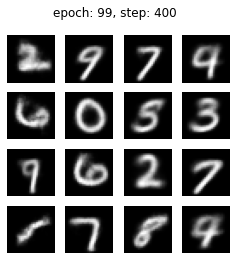

Epoch: 99 step: 400 mean loss = 142.0562


In [ ]:
epochs = 100

random_vector_for_generation = tf.random.normal(shape=[16, latent_dim])
generate_and_save_images(decoder, 0, 0, random_vector_for_generation)

for epoch in range(epochs):
    print('Start of epoch %d' % (epoch, ))

    for step, x_batch_train in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            reconstructed = vae(x_batch_train)

            flattened_inputs = tf.reshape(x_batch_train, shape=[-1])
            flattened_outputs = tf.reshape(reconstructed, shape=[-1])
            loss = bce_loss(flattened_inputs, flattened_outputs) * 784
            loss += sum(vae.losses)

        grads = tape.gradient(loss, vae.trainable_weights)
        optimizer.apply_gradients(zip(grads, vae.trainable_weights))
        loss_metric(loss)

        if step % 100 == 0:
            display.clear_output(wait=False)
            generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
            print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))

**Referencias**

* https://arxiv.org/abs/1312.6114v10
* https://paperswithcode.com/method/vae
* https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf
* https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73

**Por hacer**

* Documentar funciones